In [1]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from models import *
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import training_utils as utils

%load_ext autoreload
%autoreload 2

In [5]:
torch.cuda.is_available()
device = torch.device('cpu')

In [6]:
train_loader, test_data = utils.get_nanotube_data()
X_test, Y_test = test_data
lr_start = 0.00001
fc_model = F3FC(7, 30, 20, 1).to(device)
optimizer = Adam(fc_model.parameters(), lr=lr_start)

In [7]:
utils.train_model(fc_model, optimizer, train_loader, device, 'mse')

  0%|          | 0/30 [00:00<?, ?it/s]

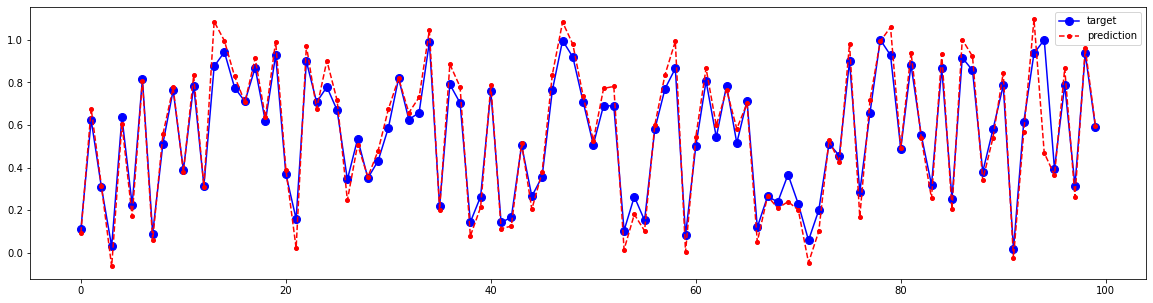

In [10]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()[:100]
    Y_pred_sample, kl = model(X_test)
    Y_pred_sample = Y_pred_sample.detach().numpy()[:100]
    plt.plot(Y_sample, "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample, "ro--", ms=4, label="prediction")
    plt.legend()
    plt.show()
plot_model_pred(fc_model, Y_test, X_test)

In [29]:
train_loader, test_data = utils.get_nanotube_data(batch_size=10)
lr_start = 0.00001
optimizer = Adam(fc_model.parameters(), lr=lr_start)

def run_model(model, optimizer, train_loader, device, loss, num_epochs=30):
    num_epochs = num_epochs
    if loss == 'mse':
        Loss_FN = torch.nn.MSELoss()
    elif loss == 'nll':
        Loss_FN = torch.nn.NLLLoss()
    else:
        print('Not Recgonized Loss Type')
        return
    pbar = tqdm(range(num_epochs))
    sd = torch.std(train_loader.dataset.y)
    for i in pbar:
        for bi, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            out, kl = model(x)
            dist = torch.distributions.normal.Normal(loc=out, scale=sd)
            # print(dist)
            # input(">>>")
            loss = torch.sum(-dist.log_prob(y))

            # loss = Loss_FN(out, y)
            loss.backward()
            optimizer.step()

        pbar.set_description(f"{loss}")


In [32]:
bayes_model = Bayesian3FC(7, 30, 20, 1).to(device)
bayes1 = BayesianFC(7, 1, [20, 20, 20]).to(device)
run_model(bayes1, optimizer, train_loader, device, 'nll')

885813.8165585219: 100%|██████████| 30/30 [00:33<00:00,  1.13s/it] 


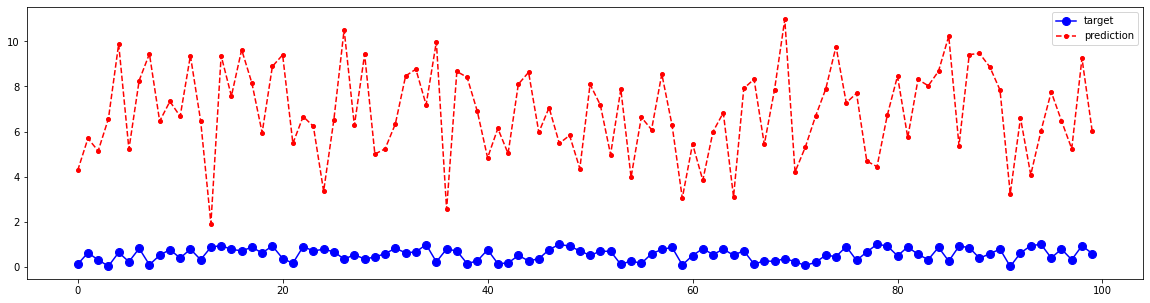

In [31]:
plot_model_pred(bayes_model, Y_test, X_test)